## SOLUTION: ODE challenge 1

In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

First read in data:

In [2]:
data = pd.read_csv("anna_ode_challenge_1_data.csv")

t_data = data["timestamp"]
x_data = data["value"]

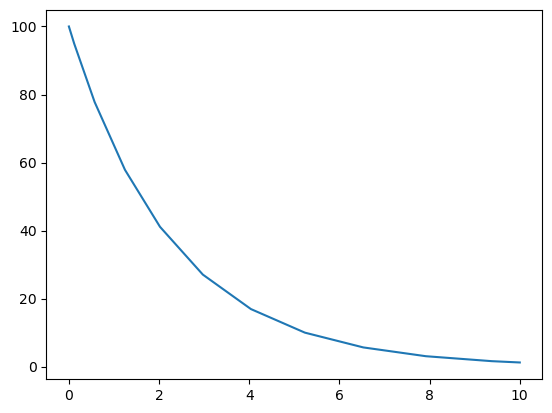

In [3]:
plt.plot(t_data,x_data)
plt.show()

### Solution method: Parameter sweep using scipy's ODEint

To solve this problem, we can sweep over different values of $\varepsilon$, using our model to produce results for each one. Then we'll compare these results to the true data and see which one reproduces the original data the closest.

In [4]:
def diffyqs(X, t, a): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    y = X
    dydt = -a*y
    return dydt

In [5]:
# initial conditions (could get these from data)
x0_1 = [x_data[0]]

# use time data as time array for solver
t = t_data


### "by hand" solution

best choice for a: 0.44


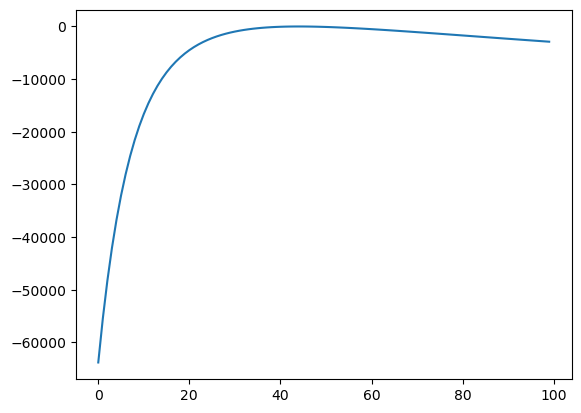

In [6]:
def log_likelihood(theta):
    a = theta
    sol = odeint(diffyqs, x0_1, t, args=(a,))
    return -np.sum((sol.T[0] - x_data)**2) ## FROM GAUSSIAN

sols = []
for i in np.arange(0,1,0.01):
    sols.append(log_likelihood(i))
print("best choice for a:",np.arange(0,1,0.01)[np.argmax(np.array(sols))])
plt.plot(sols)
plt.show()

## Solution with PyVBMC

In [7]:
D = 1  

LB = np.full((1, D), 0)  # Lower bounds 
UB = np.full((1, D), 10)  # Upper bounds 

PLB = np.copy(LB)
PUB = np.copy(UB) 
PUB[0][0] = 1
PLB[0][0] = 0.1

x0 = 3 * np.ones((1, D))

In [8]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Casting lower bounds to floating point.
Casting upper bounds to floating point.
Casting plausible lower bounds to floating point.
Casting plausible upper bounds to floating point.
vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -7.35         0.18 253945440897436581888.00        2        inf     start warm-up
     1         15          -6.90         0.00         0.00        2        inf     
     2         20          -6.92         0.00         0.00        2      0.103     
     3         25          -6.90         0.00         0.00        2     0.0936     
     4         30          -

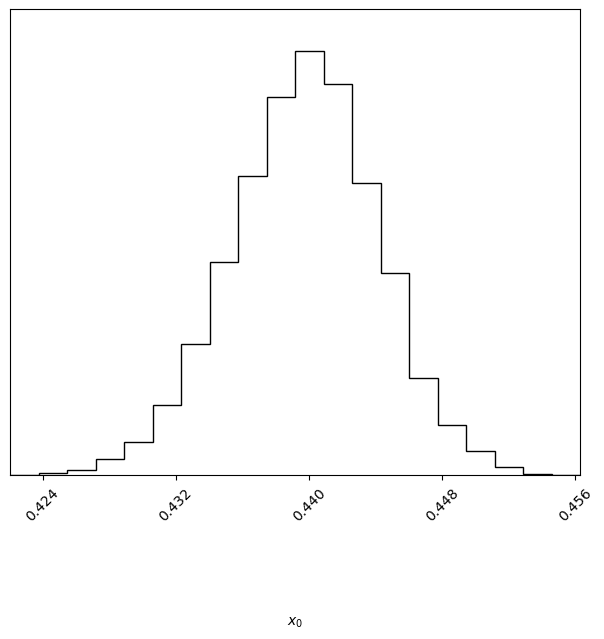

In [9]:
vp.plot();

The approximate value of a: [0.4397412]


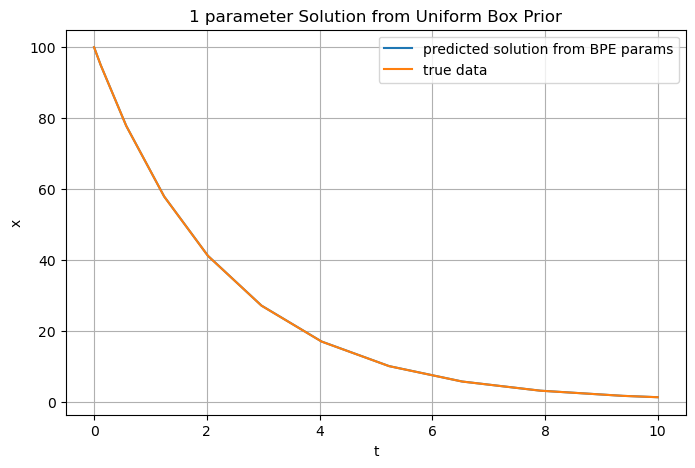

In [10]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate value of a:", post_mean)


a =  post_mean[0]

sol = odeint(diffyqs, x0_1, t, args=(a,))

plt.figure(figsize=(8,5))
plt.title("1 parameter Solution from Uniform Box Prior")
plt.plot(t,sol.T[0], label = "predicted solution from BPE params")
plt.plot(t,x_data, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

In [16]:
def diffyqs(X, t, a, b): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    y = X
    dydt = -(a + b)*y
    return dydt

# initial conditions (could get these from data)
x0_1 = [x_data[0]]

# use time data as time array for solver
t = t_data

def log_likelihood(theta):
    a,b = theta
    sol = odeint(diffyqs, x0_1, t, args=(a,b))
    return -np.sum((sol.T[0] - x_data)**2) ## FROM GAUSSIAN

D = 2

LB = np.full((1, D), 0)  # Lower bounds 
UB = np.full((1, D), 1000)  # Upper bounds 

PLB = np.copy(LB)
PUB = np.copy(UB) 
PUB[0][0] = 10
PLB[0][0] = 0.1

PUB[0][1] = 10
PLB[0][1] = 0.1

x0 = 3 * np.ones((1, D))

In [25]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize(); # do optimization (might take a while)

Casting lower bounds to floating point.
Casting upper bounds to floating point.
Casting plausible lower bounds to floating point.
Casting plausible upper bounds to floating point.
vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       -8824.70      1062.98 162160792.66        2        inf     start warm-up
     1         15         329.64       535.77     37348.33        2        inf     
     2         20         -22.65         0.29      3969.23        2   9.47e+04     
     3         25         102.05       241.04        78.68        2   3.07e+03     
     4         30          -9.65         8.81        15.94        2        777     
     5         35         -22.48         0.01         0.23        2       48.2     
     6         4

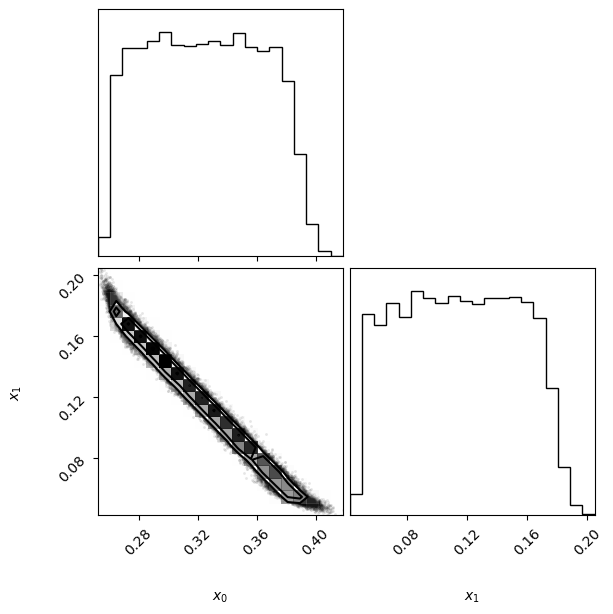

In [26]:
vp.plot();

The approximate value of a: [0.32510616 0.11527652]


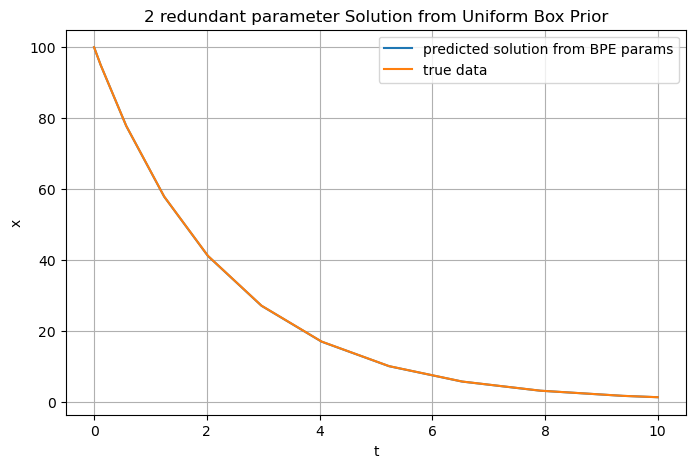

In [27]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate value of a:", post_mean)


a =  post_mean[0]
b =  post_mean[1]

sol = odeint(diffyqs, x0_1, t, args=(a,b))

plt.figure(figsize=(8,5))
plt.title("2 redundant parameter Solution from Uniform Box Prior")
plt.plot(t,sol.T[0], label = "predicted solution from BPE params")
plt.plot(t,x_data, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()